In [1]:
%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
%store -r yy 
%store -r le

no stored variable x_train
no stored variable x_test
no stored variable y_train
no stored variable y_test
no stored variable yy
no stored variable le


In [2]:
import numpy as np
max_pad_len = 174

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [3]:
# Load various imports 
import pandas as pd
import os
import librosa

fulldatasetpath = '/Users/PC/Deep learning/Notebooks/urbansound8k/'

metadata = pd.read_csv('/Users/PC/Deep learning/UrbanSound Dataset sample/metadata/UrbanSound8K.csv')

features = []

for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class_name"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  8732  files


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 



C:\Users\PC\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [6]:
num_rows = 40
num_columns = 174

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, 1)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, 1)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 41, 64)        

In [11]:
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

1747/1747 [==============================] - 2s 1000us/step
Pre-training accuracy: 9.4448%


In [31]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='/Users/PC/Deep learning/Notebooks/saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 27s 4ms/step - loss: 0.2259 - accuracy: 0.9214 - val_loss: 0.3313 - val_accuracy: 0.9033

Epoch 00001: val_loss improved from inf to 0.33133, saving model to /Users/PC/Deep learning/Notebooks/saved_models/weights.best.basic_cnn.hdf5
Epoch 2/100
6985/6985 [==============================] - 27s 4ms/step - loss: 0.2189 - accuracy: 0.9250 - val_loss: 0.3282 - val_accuracy: 0.8975

Epoch 00002: val_loss improved from 0.33133 to 0.32816, saving model to /Users/PC/Deep learning/Notebooks/saved_models/weights.best.basic_cnn.hdf5
Epoch 3/100
6985/6985 [==============================] - 27s 4ms/step - loss: 0.2214 - accuracy: 0.9236 - val_loss: 0.3501 - val_accuracy: 0.8987

Epoch 00003: val_loss did not improve from 0.32816
Epoch 4/100
6985/6985 [==============================] - 28s 4ms/step - loss: 0.2042 - accuracy: 0.9280 - val_loss: 0.3197 - val_accuracy: 0.9118

Epoch 00004: val_loss i

6985/6985 [==============================] - 28s 4ms/step - loss: 0.1481 - accuracy: 0.9506 - val_loss: 0.2972 - val_accuracy: 0.9153

Epoch 00038: val_loss did not improve from 0.27761
Epoch 39/100
6985/6985 [==============================] - 28s 4ms/step - loss: 0.1398 - accuracy: 0.9526 - val_loss: 0.2984 - val_accuracy: 0.9170

Epoch 00039: val_loss did not improve from 0.27761
Epoch 40/100
6985/6985 [==============================] - 28s 4ms/step - loss: 0.1390 - accuracy: 0.9506 - val_loss: 0.3113 - val_accuracy: 0.9113

Epoch 00040: val_loss did not improve from 0.27761
Epoch 41/100
6985/6985 [==============================] - 28s 4ms/step - loss: 0.1285 - accuracy: 0.9546 - val_loss: 0.3161 - val_accuracy: 0.9153

Epoch 00041: val_loss did not improve from 0.27761
Epoch 42/100
6985/6985 [==============================] - 28s 4ms/step - loss: 0.1424 - accuracy: 0.9499 - val_loss: 0.2879 - val_accuracy: 0.9164

Epoch 00042: val_loss did not improve from 0.27761
Epoch 43/100
6985/

6985/6985 [==============================] - 33s 5ms/step - loss: 0.0982 - accuracy: 0.9655 - val_loss: 0.3061 - val_accuracy: 0.9204

Epoch 00077: val_loss did not improve from 0.26134
Epoch 78/100
6985/6985 [==============================] - 32s 5ms/step - loss: 0.1011 - accuracy: 0.9651 - val_loss: 0.2851 - val_accuracy: 0.9262

Epoch 00078: val_loss did not improve from 0.26134
Epoch 79/100
6985/6985 [==============================] - 32s 5ms/step - loss: 0.1042 - accuracy: 0.9636 - val_loss: 0.2966 - val_accuracy: 0.9216

Epoch 00079: val_loss did not improve from 0.26134
Epoch 80/100
6985/6985 [==============================] - 33s 5ms/step - loss: 0.1116 - accuracy: 0.9592 - val_loss: 0.3018 - val_accuracy: 0.9199

Epoch 00080: val_loss did not improve from 0.26134
Epoch 81/100
6985/6985 [==============================] - 32s 5ms/step - loss: 0.0993 - accuracy: 0.9635 - val_loss: 0.2848 - val_accuracy: 0.9227

Epoch 00081: val_loss did not improve from 0.26134
Epoch 82/100
6985/

In [38]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.989692211151123
Testing Accuracy:  0.9227246642112732


In [39]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, 1)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [40]:
#drilling
filename = '/Users/PC/Deep learning/UrbanSound Dataset sample/audio/103199-4-0-0.wav' 
print_prediction(filename) 

The predicted class is: drilling 

air_conditioner 		 :  0.00000000096021868234430485244957
car_horn 		 :  0.00000000000000011661610804618305
children_playing 		 :  0.00000000176181946809350620242185
dog_bark 		 :  0.00000000000019882251227343328281
drilling 		 :  0.99999308586120605468750000000000
engine_idling 		 :  0.00000000131292154925688464572886
gun_shot 		 :  0.00000000000018252357904171429004
jackhammer 		 :  0.00000682402060192544013261795044
siren 		 :  0.00000000001389500146886657461209
street_music 		 :  0.00000010089981117289426038041711


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

In [41]:
#air_conditioner 
filename = '/Users/PC/Deep learning/UrbanSound Dataset sample/audio/100852-0-0-0.wav'
print_prediction(filename) 

The predicted class is: air_conditioner 

air_conditioner 		 :  1.00000000000000000000000000000000
car_horn 		 :  0.00000000000000005783933378334958
children_playing 		 :  0.00000001089141576926522247958928
dog_bark 		 :  0.00000000000236615154552977102753
drilling 		 :  0.00000000017974469135317860946088
engine_idling 		 :  0.00000000000691622367016142547413
gun_shot 		 :  0.00000000093781726828723321887082
jackhammer 		 :  0.00000000012537700044834565460405
siren 		 :  0.00000000166928770806151760552893
street_music 		 :  0.00000000000282763244242867362033


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

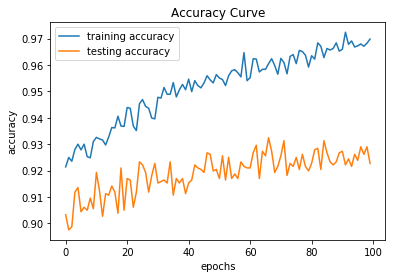

In [62]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='testing accuracy')
plt.title('Accuracy Curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

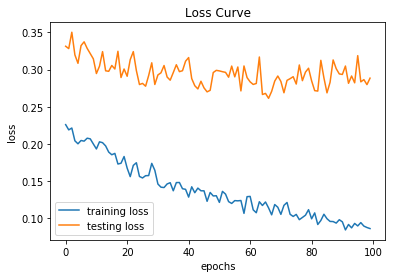

In [63]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='testing loss')
plt.title('Loss Curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
y_probs = model.predict(x_test)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test, axis=1)

In [65]:
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)
print(cm)


[[190   0   1   3   0   5   0   0   1   3]
 [  2  83   0   0   0   0   0   0   1   0]
 [  2   0 162   7   0   3   0   0   4   5]
 [  0   1   2 188   1   2   3   0   3   1]
 [  3   0   3   2 185   2   2   5   1   3]
 [  0   0   1   1   1 190   0   0   0   0]
 [  0   0   0   1   0   0  70   1   0   0]
 [  1   0   0   0   9   0   0 197   0   1]
 [  0   0   2   2   0   1   0   0 160   0]
 [  8   1  21   2   0   3   0   2   6 187]]


In [66]:
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

# Build classification report
report = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(report)

                  precision    recall  f1-score   support

 Air Conditioner       0.92      0.94      0.93       203
        Car Horn       0.98      0.97      0.97        86
Children Playing       0.84      0.89      0.86       183
        Dog bark       0.91      0.94      0.92       201
        Drilling       0.94      0.90      0.92       206
   Engine Idling       0.92      0.98      0.95       193
        Gun Shot       0.93      0.97      0.95        72
      Jackhammer       0.96      0.95      0.95       208
           Siren       0.91      0.97      0.94       165
    Street Music       0.94      0.81      0.87       230

     avg / total       0.92      0.92      0.92      1747

